In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import json
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### Z TS
$$Z_{t} = Ln\left (\frac{S_{t}}{\widehat{S_{t}}}\right )$$

In [2]:
#Load residuals as z and set index as datetime
z_df = pd.read_json('json/residuals_stack.json', orient='index')

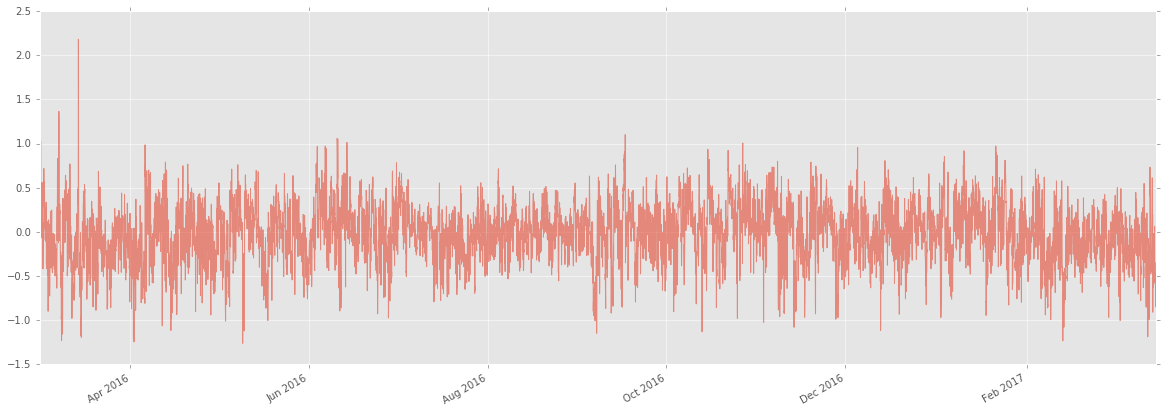

In [3]:
#Plot Z TS
fig, ax0 = plt.subplots(1,1, figsize=(20,7))
z_df['log_res'].plot(ax=ax0, alpha=0.6);

### Dick-Fuller test on stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
def perform_stationarity_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutpout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used',
                                             'Number of observation used'])
    for key, value in dftest[4].items():
        dfoutpout['Critical value (%s)'%key] = value
    print(dfoutpout)

In [7]:
perform_stationarity_test(z_df['log_res'])

Results of the Dickey-Fuller Test:
Test Statistic               -1.358907e+01
p-value                       2.053320e-25
#Lags used                    2.500000e+01
Number of observation used    9.117000e+03
Critical value (5%)          -2.861857e+00
Critical value (10%)         -2.566939e+00
Critical value (1%)          -3.431067e+00
dtype: float64


### ACF and PACF

In [8]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
def computer_acf_pacf(timeseries, acf_lags, pacf_lags):
    lag_acf = acf(timeseries, nlags=acf_lags)
    lag_acf_df = pd.DataFrame(lag_acf, columns=['ACF'])
    lag_acf_df.index.name = 'Hour'
    
    lag_pacf = pacf(timeseries.dropna(), nlags=pacf_lags)
    lag_pacf_df = pd.DataFrame(lag_pacf, columns=['PACF'])
    lag_pacf_df.index.name = 'Hour'
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))
    lag_acf_df.iloc[:100].plot(kind='bar', ax=ax0)
    #ax0.axhline(y=-1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    #ax0.axhline(y=+1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    lag_pacf_df.iloc[:100].plot(kind='bar', ax=ax1);
    #ax1.axhline(y=-1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')
    #ax1.axhline(y=+1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')

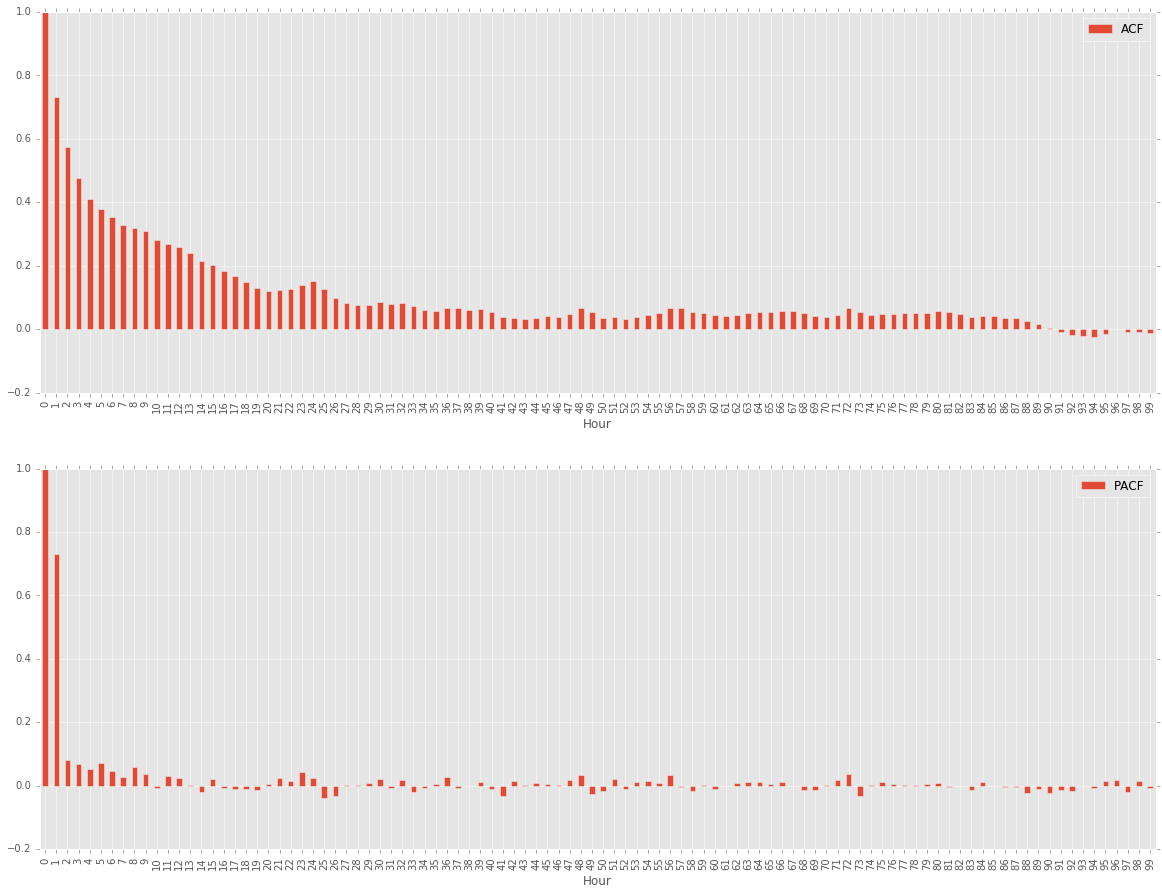

In [11]:
#ACF and PACF suggest an AR model with p = 24, since Hour 0 to 23 cannot be used
computer_acf_pacf(z_df['log_res'], 720, 720)

### ARIMA model, p=24, 25

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [13]:
ar = np.zeros(25)

In [14]:
ar[-1] = 1
ar[-2] = 1

In [15]:
ar

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.])

In [17]:
model = SARIMAX(endog=z_df['log_res'].values, order=(ar,0,0))

In [18]:
%%time
results = model.fit(maxiter=400, disp=-1)

Wall time: 3.73 s


In [19]:
print(results.summary())

                              Statespace Model Results                             
Dep. Variable:                           y   No. Observations:                 9143
Model:             SARIMAX((24, 25), 0, 0)   Log Likelihood               -2652.081
Date:                     Sat, 08 Apr 2017   AIC                           5310.163
Time:                             20:26:44   BIC                           5331.525
Sample:                                  0   HQIC                          5317.426
                                    - 9143                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L24         0.1261      0.013      9.520      0.000       0.100       0.152
ar.L25         0.0407      0.014      2.966      0.003       0.014       0.068
sigma2      

In [20]:
results.resid.std()

0.32278228740147524

In [21]:
def compute_SARIMAX_model(timeseries, p, d, q):
    """
    Computes the SARIMAX model for a given timeseries with order p, d, q
    """
    model = SARIMAX(endog=timeseries.values, order=(p,d,q))
    fitted_model = model.fit(disp=-1, maxiter=400)
    return fitted_model

In [22]:
def check_cv_fold(timeseries, train_index, test_index, p, d, q):
    """
    Computes the 24-hour following error for an specific CV fold 
    """
    model = compute_SARIMAX_model(timeseries.iloc[train_index], p, d, q)
    y_pred = model.forecast(steps=24)
    y_true = timeseries.iloc[test_index].values[:24]
    error = mean_squared_error(y_true, y_pred)
    train_residuals = np.mean(model.resid**2)
    print('train length: %d, train MSE %.4f, test MSE %.4f' %(len(train_index), train_residuals, error))
    return train_residuals, error

In [24]:
%%time
tscv = TimeSeriesSplit(n_splits=10)
train_error = list()
test_error = list()
for train_index, test_index in tscv.split(z_df['log_res'].values):
    tr_error, ts_error = check_cv_fold(z_df['log_res'], train_index, test_index, ar, 0, 0)
    train_error.append(tr_error)
    test_error.append(ts_error)
print('CV Train MSE: %.4f, Test MSE: %.4f' %(np.mean(train_error), np.mean(test_error)))

train length: 833, train MSE 0.1440, test MSE 0.2073
train length: 1664, train MSE 0.1362, test MSE 0.5062
train length: 2495, train MSE 0.1301, test MSE 0.1802
train length: 3326, train MSE 0.1173, test MSE 0.1231
train length: 4157, train MSE 0.1049, test MSE 0.0310
train length: 4988, train MSE 0.1039, test MSE 0.0385
train length: 5819, train MSE 0.1051, test MSE 0.0404
train length: 6650, train MSE 0.1056, test MSE 0.0679
train length: 7481, train MSE 0.1041, test MSE 0.1132
train length: 8312, train MSE 0.1051, test MSE 0.1017
CV Train MSE: 0.1156, Test MSE: 0.1410
Wall time: 21.7 s


In [25]:
fitted_model = compute_SARIMAX_model(z_df['log_res'], ar, 0, 0)

In [26]:
fitted_model.arparams

array([ 0.12608768,  0.04072681,  0.10458259])

In [27]:
fitted_model.resid.std()

0.32278228740147524

$$Z_{t} = \alpha_{24} \cdot Z_{t-24} + \epsilon _{t}$$

$$\epsilon _{t} \sim N(0, \sigma _{x} ^{2})$$

In [34]:
#Export armaparams into a json
arima_parameters ={
    'ar':fitted_model.arparams.tolist()[:-1],
    'std':fitted_model.resid.std()
}

with open('json/arima_band_parameters_stack_model.json', 'w') as f:
     json.dump(arima_parameters, f)